In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
from torchvision.datasets import ImageFolder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import albumentations as A
import wandb
import nbformat
from tqdm import tqdm

import logging
import os
import cv2

c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
wandb.login()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: prince_. Use `wandb login --relogin` to force relogin


True

In [3]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)

Using cache found in C:\Users\user/.cache\torch\hub\pytorch_vision_v0.10.0
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
transform_training = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), p=0.2),
    A.Blur(blur_limit=3 ,p=0.35),
    A.Sharpen(alpha=(0.1, 0.2) ,p=0.3)
])

transform_val_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

data_transforms = {
    "train": transform_training,
    "validation": transform_val_test,
    "test": transform_val_test
}
    

In [5]:
class MultiAugmentDataset(Dataset):
    def __init__(self, root_dir):
        self.dataset = ImageFolder(root_dir)
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):

        image_path, label = self.dataset.samples[original_index]
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        return image, label

In [6]:
data_directory = "C:/Users/user/Desktop/analysis/original(resized)"

In [7]:
image_datasets = {
    "train": MultiAugmentDataset(os.path.join(data_directory, "train"), transform=data_transforms["train"]),
    "validation": ImageFolder(os.path.join(data_directory, "validation"), transform=data_transforms["validation"]),
    "test": ImageFolder(os.path.join(data_directory, "test"), transform=data_transforms["test"])
}

In [8]:
dataloader = {
    "train": DataLoader(image_datasets["train"], batch_size=8, shuffle=True, num_workers=6),
    "validation": DataLoader(image_datasets["validation"], batch_size=16, shuffle=True, num_workers=6),
    "test": DataLoader(image_datasets["test"], batch_size=16, shuffle=True, num_workers=6)
}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'validation', 'test']}
print(dataset_sizes)

class_names = image_datasets['train'].dataset.classes
print(class_names)

num_classes = len(class_names)
print(f"Number of classes: {num_classes}")

{'train': 3093, 'validation': 128, 'test': 130}
['Anthracnose_Fungi', 'Bacterial_Wilt_Bacteria', 'Belly_Rot_Fungi', 'Downy_Mildew_Fungi', 'Gummy_Stem_Blight_Fungi', 'Healthy_Crop_Cucumber', 'Healthy_Crop_Leaf', 'Pythium_Fruit_Rot_Fungi']
Number of classes: 8


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

In [10]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [11]:
in_features = model.fc.in_features

model.fc = torch.nn.Linear(in_features=in_features, out_features=num_classes)

In [12]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [11]:
# for name, param in model.named_parameters():
#     if 'fc' in name:
#         param.requires_grad = True
#     else:
#         param.requires_grad = False

In [13]:
num_epochs = 5
lr = 0.001

model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=lr)

In [14]:
run = wandb.init(
    # Set the project where this run will be logged
    project="milan-project",
    notes="Training resnet18 without freezing parameters on augmented images",
    # Track hyperparameters and run metadata
    config={
        "learning_rate": lr,
        "epochs": num_epochs,
        "architecture": "resnet18",
        "dataset": "augmented"
    },
)

In [15]:
wandb.watch(model, log="all")

[]

In [16]:
notebook_name = "NN_resnet18_aug.ipynb"
with open(notebook_name) as f:
    nb = nbformat.read(f, as_version=4)
artifact = wandb.Artifact('notebook', type='notebook')
artifact.add_file(notebook_name)
wandb.log_artifact(artifact)

<Artifact notebook>

In [17]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')

In [18]:
def train_one_epoch(epoch, model, dataloader, criterion, optimizer, device):
    model.train()

    # if epoch == 5:
    #     for param in model.parameters():
    #         param.requires_grad = True

    running_loss = 0.0
    for inputs, labels in tqdm(dataloader, desc=f"Epoch: {epoch + 1}"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_loss = running_loss/len(dataloader)
    logging.info(f"Epoch: [{epoch+1}], Training Loss: {avg_loss: .4f}")
    return avg_loss

def validation(epoch, model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
    avg_loss = running_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    logging.info(f"Epoch: [{epoch+1}], Validation Loss: {avg_loss: .4f}, Accuracy: {accuracy: .4f}, Precision: {precision: .4f}, Recall: {recall: .4f}, F1 Score: {f1: .4f}")
    return avg_loss, accuracy, precision, recall, f1


def test(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
    avg_loss = running_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion matrix")
    plt.show

    wandb.log({'test loss': avg_loss, 'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1 score': f1})
    logging.info(f"Test Loss: {avg_loss: .4f}, Accuracy: {accuracy: .4f}, Precision: {precision: .4f}, Recall: {recall: .4f}, F1 Score: {f1: .4f}")
    return avg_loss, accuracy, precision, recall, f1

In [19]:
for epoch in range(num_epochs):
    train_one_epoch(epoch, model, dataloader['train'], criterion, optimizer, device)
    validation(epoch, model, dataloader['validation'], criterion, device)

Epoch: 1:   0%|          | 0/387 [00:00<?, ?it/s]

2024-06-05 15:33:49,382 Test Loss:  0.3022, Accuracy:  0.8923, Precision:  0.9114, Recall:  0.8923, F1 Score:  0.8945


(0.30220852320957364,
 0.8923076923076924,
 0.911371705217859,
 0.8923076923076924,
 0.8945193492116974)

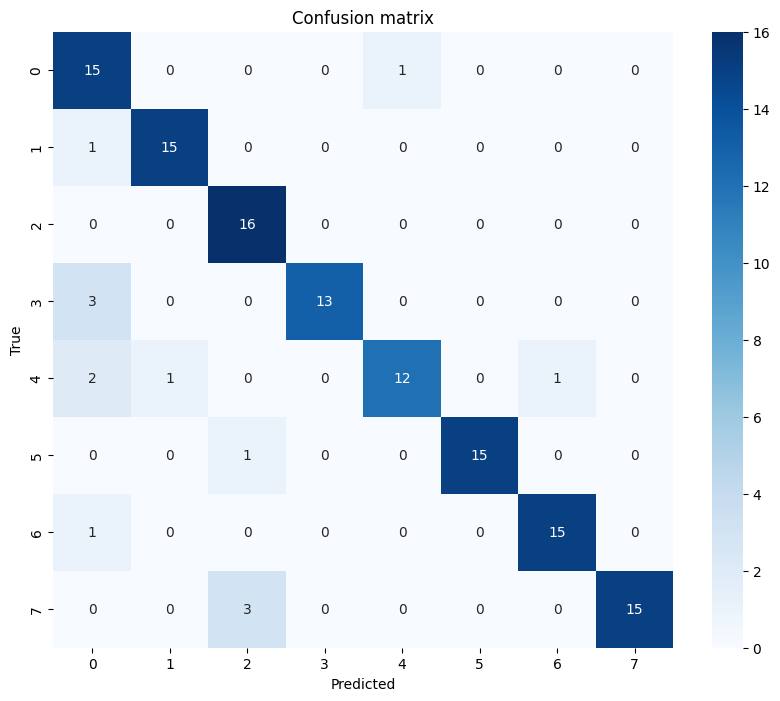

In [17]:
test(model, dataloader['test'], criterion, device)

In [ ]:
model_name = 'resnet18.pth'

torch.save(model.state_dict(), model_name)
model_artifact = wandb.Artifact('model', type='model')
model_artifact.add_file(model_name)

In [18]:
wandb.log_artifact(model_artifact)

ValueError: You must pass an instance of wandb.Artifact or a valid file path to log_artifact

In [19]:
wandb.finish()

accuracy,▁
f1 score,▁
precision,▁
recall,▁
test loss,▁
accuracy,0.89231
f1 score,0.89452
precision,0.91137
recall,0.89231
test loss,0.30221
